---
title: Introduction to Config-Based Plotting
---

In [24]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

# 1. Use retina for crisp, PDF-like text
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

# 2. Set a high baseline DPI
plt.rcParams["figure.dpi"] = 150

## The `xmris` Plotting Philosophy

Generating publication-ready figures directly from code often results in function signatures cluttered with dozens of keyword arguments (`figsize`, `cmap`, `linewidth`, etc.).

To solve this, `xmris` utilizes a **Config-Based Plotting Architecture**. Every complex plotting function is accessed via the `xarray` accessor (e.g., `da.xmr.plot.ridge()`) and accepts a single, dedicated Configuration Object. This provides a clean API while maintaining infinite customizability.

### The Ridge Plot Example
Ridge plots are commonly used in MRS to visualize how spectra change over time by vertically stacking and offsetting individual 1D plots. In xmris, this visualization is built using Matplotlib's [fill_between](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.fill_between.html) to create the shaded, overlapping profiles.

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Import the global configuration and the RidgePlotConfig object
import xmris
from xmris.visualization.plot import PlotRidgeConfig

### 1. Generating Synthetic Kinetic Data
Let's simulate a standard 1D spectrum over a time series where one metabolite decays and another grows. Notice how we attach units to the `xarray.DataArray` metadata; `xmris` plotting functions will extract these automatically.

In [26]:
rng = np.random.default_rng()
ppm = np.linspace(190, 160, 500)
time = np.linspace(0, 132, 40)
spectra = np.zeros((len(time), len(ppm)))


def gaussian(x, mu, sigma, A):
    """Calculate simple gaussian curve."""
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma**2))


for i, t in enumerate(time):
    decay = np.exp(-t / 50)
    growth = 1 - np.exp(-t / 50)
    spectra[i, :] = (
        gaussian(ppm, 183, 0.8, 10 * decay)
        + gaussian(ppm, 171, 0.6, 8 * growth)
        + rng.normal(0, 0.15, len(ppm))
    )

da_kinetic = xr.DataArray(
    spectra,
    dims=["time", "chemical_shift"],
    coords={"time": time, "chemical_shift": ppm},
    name="Signal",
)

da_kinetic.coords["time"].attrs["units"] = "s"
da_kinetic.coords["chemical_shift"].attrs["units"] = "ppm"

da_kinetic

<xarray.DataArray 'Signal' (time: 40, chemical_shift: 500)> Size: 160kB
array([[ 6.15204903e-02,  2.18181353e-01, -3.03959705e-02, ...,
        -6.43749083e-02,  1.78974239e-01,  1.80571791e-02],
       [ 5.55380139e-02, -8.08535884e-02,  1.07040243e-01, ...,
         1.23289455e-04,  3.05599387e-01, -1.08344574e-01],
       [ 2.34901140e-01,  8.38190249e-03,  2.92037616e-02, ...,
         1.42891510e-01, -1.88972178e-01,  1.64514205e-01],
       ...,
       [ 6.09862607e-02, -1.73279662e-01,  6.48329219e-03, ...,
         2.10902089e-01, -1.07343528e-01, -1.46900228e-01],
       [-2.31890127e-02,  2.10322678e-01, -2.39452177e-01, ...,
        -1.82164593e-02,  2.76334110e-01, -3.67870822e-02],
       [-1.24738034e-01, -2.30287549e-01, -7.49706277e-02, ...,
        -7.91755365e-02,  1.61467683e-01, -1.41141518e-01]])
Coordinates:
  * time            (time) float64 320B 0.0 3.385 6.769 ... 125.2 128.6 132.0
  * chemical_shift  (chemical_shift) float64 4kB 190.0 189.9 ... 160.1 160.0

### 2. The Configuration Object
Instead of passing arguments directly to the plot, we instantiate a `PlotRidgeConfig`. Because `xmris` configs inherit from a rich base class, simply outputting the object in a Jupyter cell renders a beautiful HTML table detailing every available parameter, its default value, and its description.

In [27]:
# Instantiate the config
CFG = PlotRidgeConfig()

# Display it in the notebook to view all available styling options
CFG

PlotRidgeConfig(figsize=(8, 6), style='seaborn-v0_8-white', fontfamily='sans-serif', offset_step=1.5, cmap='magma', cmap_start=0.8, cmap_end=0.1, fill_alpha=0.75, linewidth=0.8, linewidth_highlight=1.3, label_every_n=10, label_x_nudge=-0.25, label_y_nudge_frac=0.0, labelsize=12, ticklabelsize=10, xlabel=None, pad_left=0.0, pad_right=0.0, xminor_locator=5, annotation='Absorption Mode')

### 3. Customizing and Plotting via the Accessor
We can modify the config object using standard `matplotlib` terminology. Because we utilize the `.xmr.plot` namespace, the function dynamically reads the dataset's units and dimensions to build the axes.

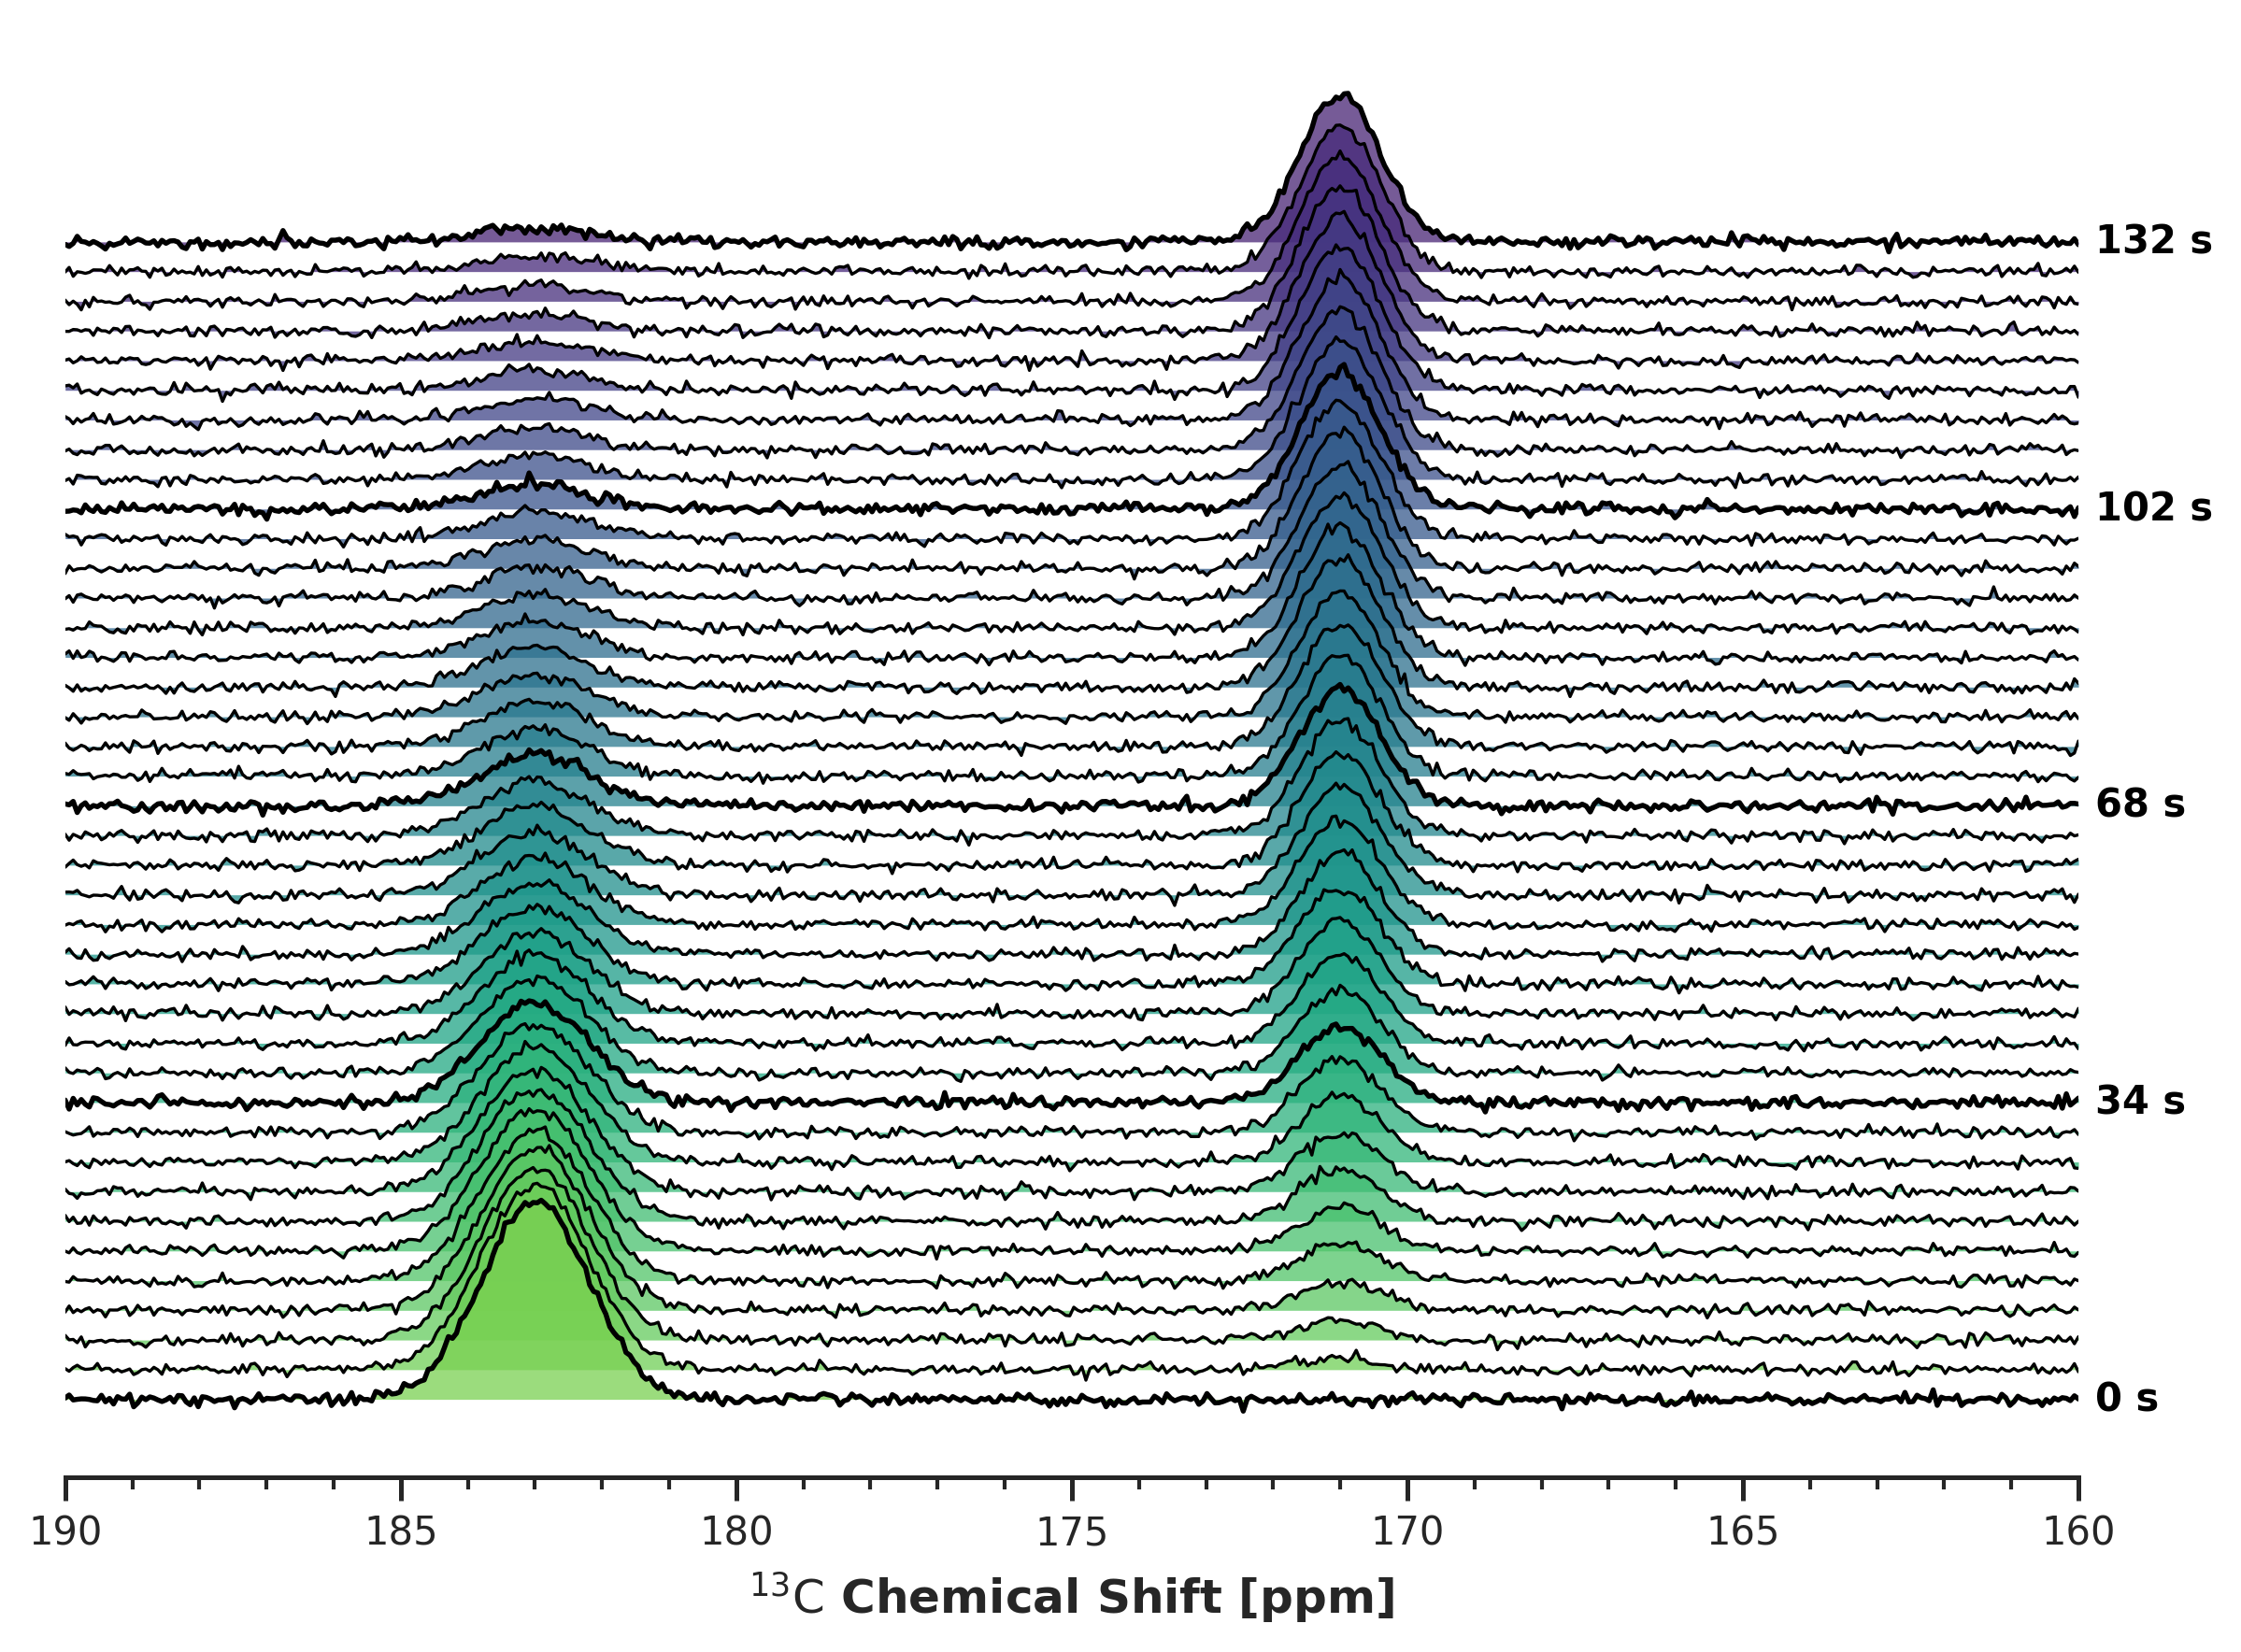

In [28]:
# Update generic plot parameters
CFG.annotation = None  # Remove the top-left annotation
CFG.xlabel = r"$^{13}\mathrm{C}$ Chemical Shift"  # Add LaTeX formatting
CFG.cmap = "viridis"  # Change the colormap

# Plot directly using the xarray accessor
ax = da_kinetic.xmr.plot.ridge(config=CFG)
plt.show()

### 4. Subplot Integration

Professional library functions should never hijack your global plotting environment. Because `plot.ridge()` returns a standard `matplotlib.Axes` object and accepts an `ax` keyword argument, you can easily embed these visualizations into complex, multi-panel figures.

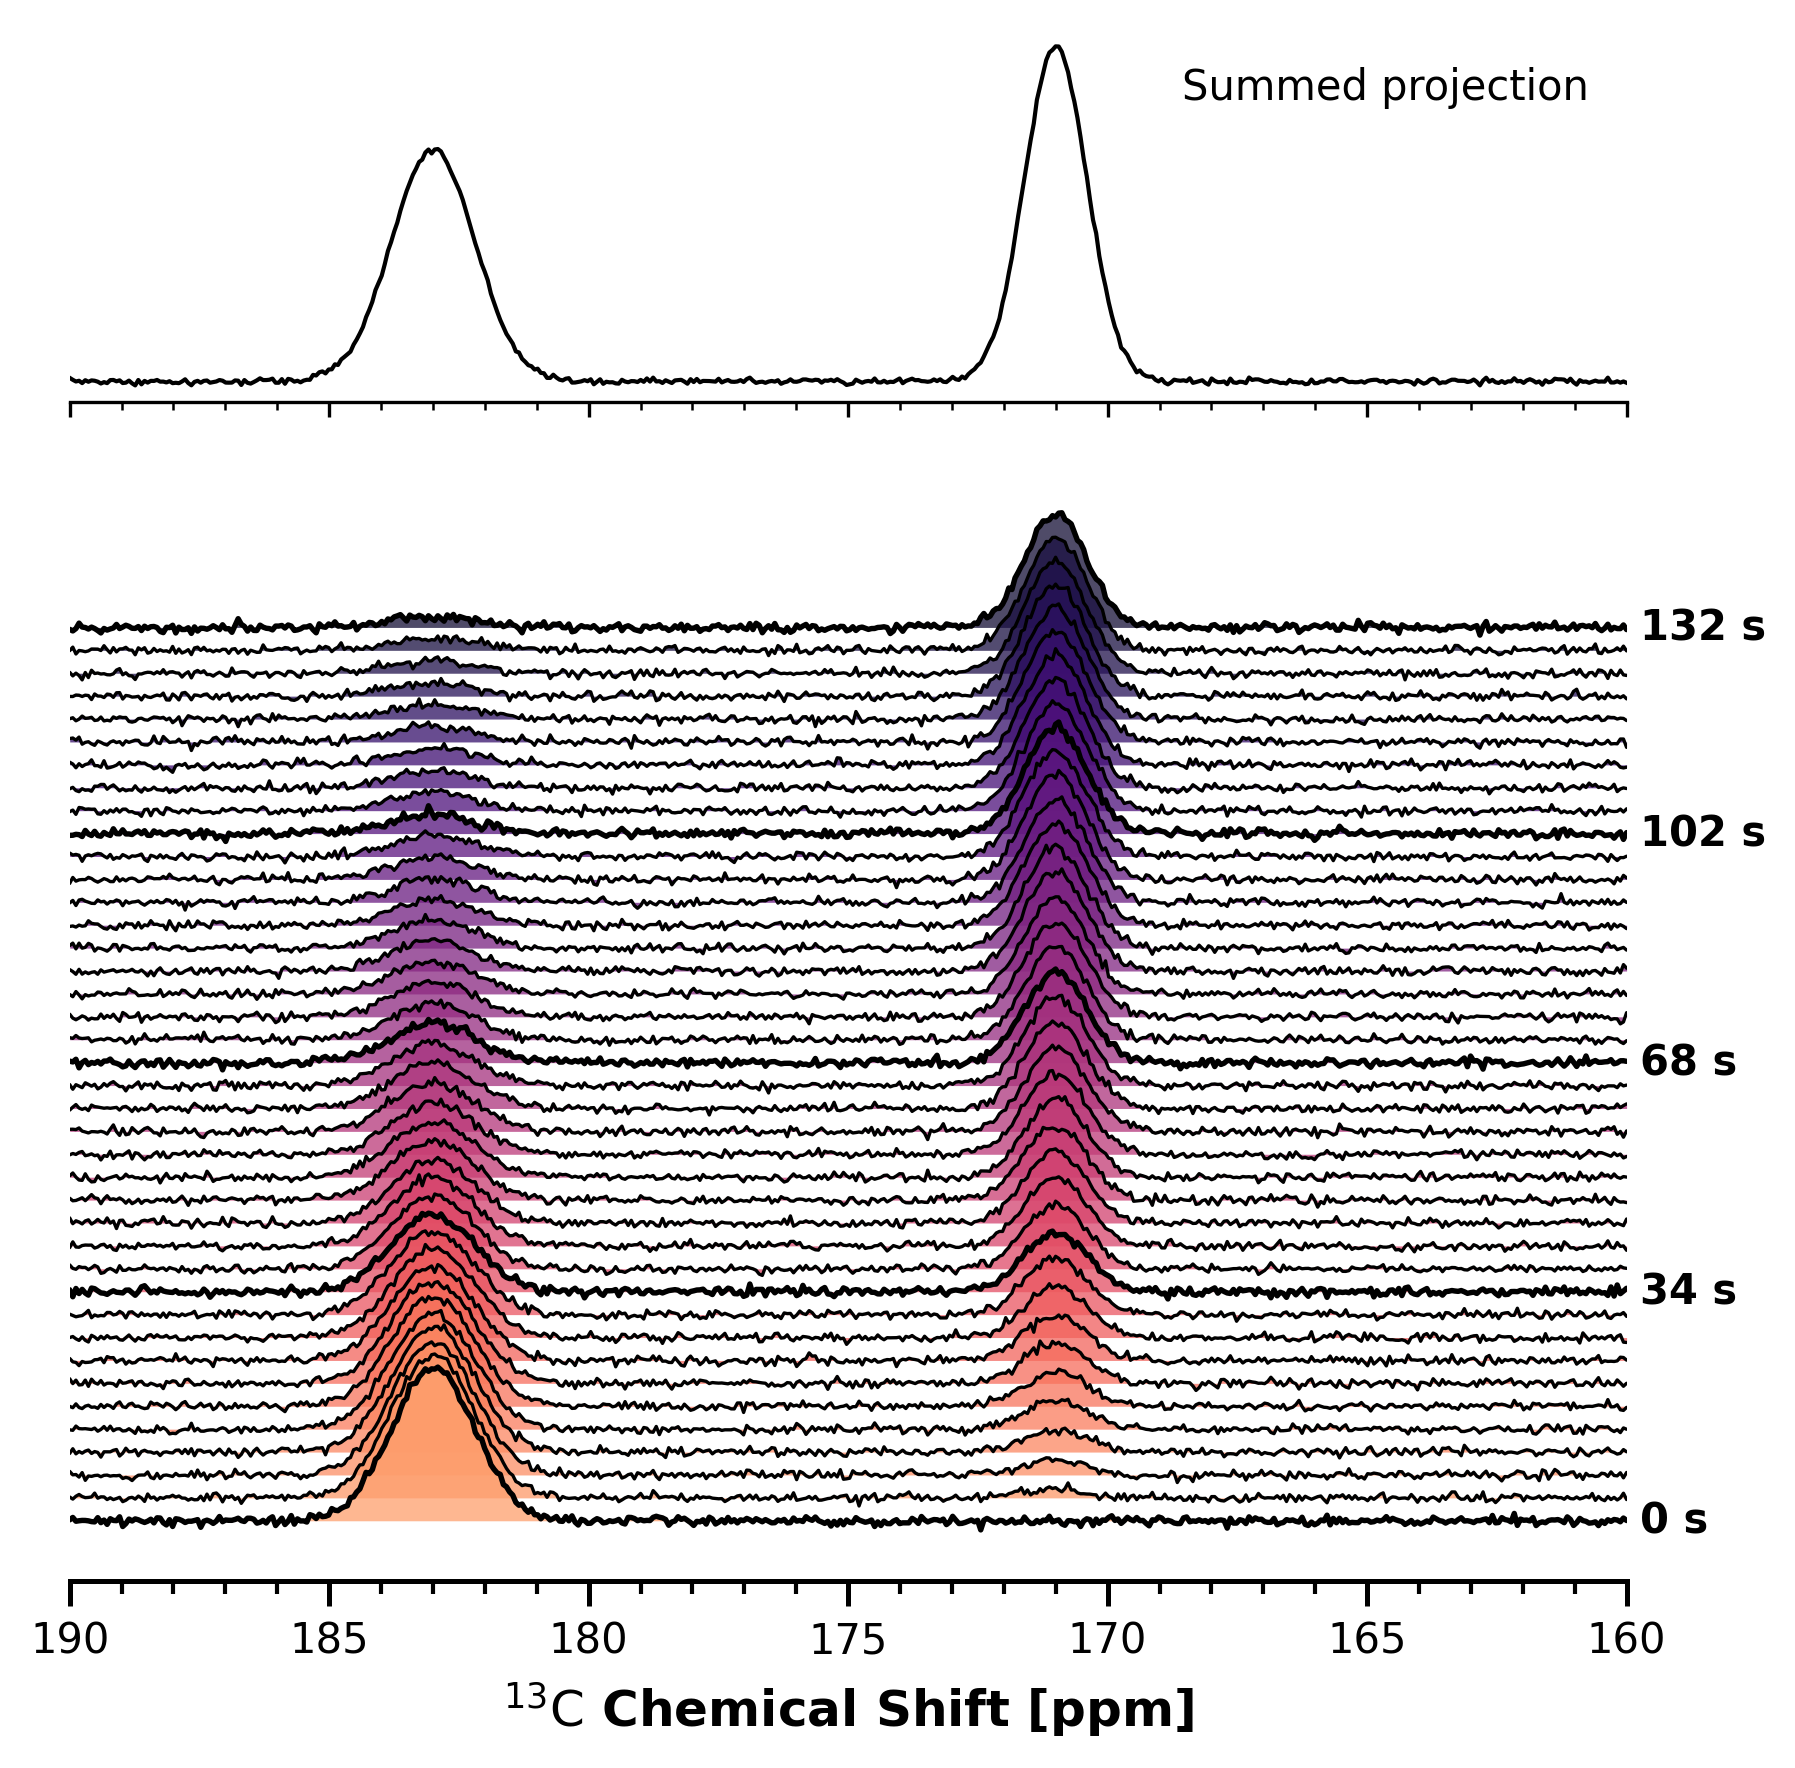

In [29]:
from matplotlib.offsetbox import AnchoredText

# Reset config to standard magma colors for the final plot
CFG.cmap = "magma"

# Create a custom multi-panel figure
fig, (ax_top, ax_bottom) = plt.subplots(
    nrows=2,
    figsize=(6, 6),
    gridspec_kw={"height_ratios": [1, 3]},
    sharex=True,
)

# 1. Plot a standard 1D summed spectrum on the top panel
da_kinetic.sum(dim="time").plot.line(ax=ax_top, color="black", linewidth=1)

# Add a floating legend box
text_box = AnchoredText(
    "Summed projection",
    loc="upper right",
    frameon=False,
    prop=dict(fontsize=10),
)
ax_top.add_artist(text_box)

ax_top.invert_xaxis()
ax_top.set_xlabel("")
ax_top.set_ylabel("")

ax_top.set_yticks([])
ax_top.spines["left"].set_visible(False)
ax_top.spines["right"].set_visible(False)
ax_top.spines["top"].set_visible(False)

# 2. Inject the ridge plot into the bottom panel using our custom config
da_kinetic.xmr.plot.ridge(ax=ax_bottom, config=CFG)

plt.tight_layout()
plt.show()

In [30]:
# STRICT TESTS FOR CI
assert isinstance(ax_bottom, plt.Axes), "plot.ridge must return a matplotlib Axes object."
assert len(ax_bottom.collections) > 0, "No filled areas were generated by fill_between."
assert len(ax_bottom.lines) > 0, "No outline lines were plotted."
x_label = ax_bottom.get_xlabel()
assert "13" in x_label and "C" in x_label, "Chemical shift LaTeX formatting failed."